# **Part 1: Q-Learning and Policy Iteration on the Frozen Lake Environment**

# **Q learning Implementation**

In [ ]:
import numpy as np

def q_learning(env,
               num_episodes=10000,
               alpha=0.1,
               gamma=0.99,
               epsilon=1.0,
               epsilon_decay=0.9997,
               min_epsilon=0.1):
    nS = env.observation_space.n
    nA = env.action_space.n
    Q = np.zeros((nS, nA))
    rewards, steps, eps_history = [], [], []


    state_counts  = np.zeros(nS, dtype=int)
    action_counts = np.zeros(nA, dtype=int)
    last_frame    = None

    for ep in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        step_count = 0

        while not done:

            state_counts[state] += 1

            # ε‑greedy action
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])
            action_counts[action] += 1

            next_s, reward, done, truncated, _ = env.step(action)
            Q[state, action] += alpha * (
                reward + gamma * Q[next_s].max() - Q[state, action]
            )
            state = next_s
            total_reward += reward
            step_count   += 1


            if ep == num_episodes - 1:
                last_frame = env.render()

        rewards.append(total_reward)
        steps.append(step_count)
        eps_history.append(epsilon)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)


    return Q, rewards, steps, eps_history, state_counts, action_counts, last_frame


# **Policy Iteration Algorithm implementation**

In [ ]:

def policy_evaluation(policy, env, gamma=0.99, theta=1e-6):
    n_states = env.observation_space.n
    V = np.zeros(n_states)
    P = env.unwrapped.P

    while True:
        delta = 0
        for s in range(n_states):
            v = 0
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in P[s][a]:
                    v += action_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, abs(v - V[s]))
            V[s] = v
        if delta < theta:
            break
    return V

def policy_iteration(env, gamma=0.99):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    P = env.unwrapped.P

    # starting with uniform random policy
    policy = np.ones((n_states, n_actions)) / n_actions

    while True:

        V = policy_evaluation(policy, env, gamma)


        policy_stable = True
        for s in range(n_states):
            old_action = np.argmax(policy[s])


            action_values = np.zeros(n_actions)
            for a in range(n_actions):
                for prob, next_state, reward, done in P[s][a]:
                    action_values[a] += prob * (reward + gamma * V[next_state])

            best_actions = np.argwhere(action_values == np.max(action_values)).flatten()
            new_action = np.zeros(n_actions)
            new_action[best_actions] = 1 / len(best_actions)

            if old_action not in best_actions:
                policy_stable = False

            policy[s] = new_action

        if policy_stable:
            break

    return policy, V

In [ ]:

def evaluate_policy(env, Q_or_policy, greedy=True, episodes=1000):
    total_rewards = []

    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        ep_reward = 0
        while not done:
            if greedy:
                action = np.argmax(Q_or_policy[state])
            else:
                action = np.random.choice(env.action_space.n, p=Q_or_policy[state])

            state, reward, done, truncated, _ = env.step(action)
            ep_reward += reward
        total_rewards.append(ep_reward)

    return np.mean(total_rewards)

# **HyperParameter Tuning**


In [ ]:
import numpy as np
import random

seed = 42
np.random.seed(seed)
random.seed(seed)

if __name__ == "__main__":

    env = gym.make("FrozenLake-v1", is_slippery=True)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)


    # Hyperparameter Tuning

    # alpha value tuning
    for alpha in [0.01, 0.1, 0.5]:
        Q_a = q_learning(env, num_episodes=5_000, alpha=alpha)[0]
        perf_a = evaluate_policy(env, Q_a)
        print(f"α={alpha:.2f} → Success rate: {perf_a:.2f}")

    # gamma value tuning
    for gamma in [0.5, 0.9, 0.99]:
        Q_g = q_learning(env, num_episodes=5000, gamma=gamma)[0]
        perf_g = evaluate_policy(env, Q_g)
        print(f"Gamma={gamma} -> Success rate: {perf_g:.2f}")

    # epsilon value tuning
    for eps in [1.0, 0.5, 0.1]:
        Q_e= q_learning(env, num_episodes=5000, epsilon=eps)[0]
        perf_e = evaluate_policy(env, Q_e)
        print(f"Epsilon={eps} -> Success rate: {perf_e:.2f}")

α=0.01 → Success rate: 0.10
α=0.10 → Success rate: 0.71
α=0.50 → Success rate: 0.82
Gamma=0.5 -> Success rate: 0.21
Gamma=0.9 -> Success rate: 0.16
Gamma=0.99 -> Success rate: 0.83
Epsilon=1.0 -> Success rate: 0.82
Epsilon=0.5 -> Success rate: 0.73
Epsilon=0.1 -> Success rate: 0.00


### **A hyperparameter tuning experiment was conducted on alpha (learning rate), gamma (discount factor), and epsilon (exploration rate). The success rates for various values were recorded. The best-performing values were α = 0.5 (82%), γ = 0.99 (83%), and ε = 1.0 (82%). These values were selected for the final model configuration based on their high success rates.**

# Q Learning vs Policy Iteration

In [ ]:
    # Q Learning
    Q= q_learning(env, num_episodes=20000, alpha=0.5, gamma=0.99,
                             epsilon=1.0, epsilon_decay=0.9997, min_epsilon=0.1)[0]
    q_perf = evaluate_policy(env, Q, greedy=True)
    print(f"Q-Learning Agent average success rate: {q_perf:.2f}")

    # Policy Iteration
    policy, V = policy_iteration(env, gamma=0.99)
    pi_perf = evaluate_policy(env, policy, greedy=False)
    print(f"Policy Iteration average success rate: {pi_perf:.2f}")

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/toy_text/frozen_lake.py:334: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("FrozenLake-v1", render_mode="rgb_array")
  gym.logger.warn(


Q-Learning Agent average success rate: 0.80
Policy Iteration average success rate: 0.82


I have implemented Q-Learning and Policy Iteration algorithm

1) Q‑Learning reached an 80 % average success rate using model‑free updates.

2) Policy Iteration achieved 82 %, slightly outperforming Q‑Learning by leveraging full knowledge of the transition model.

3) Both algorithms learn strong policies here, with Policy Iteration holding a small edge when the dynamics are known.

## **Visualization of Q Learning on Frozen Lake environment**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:413: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


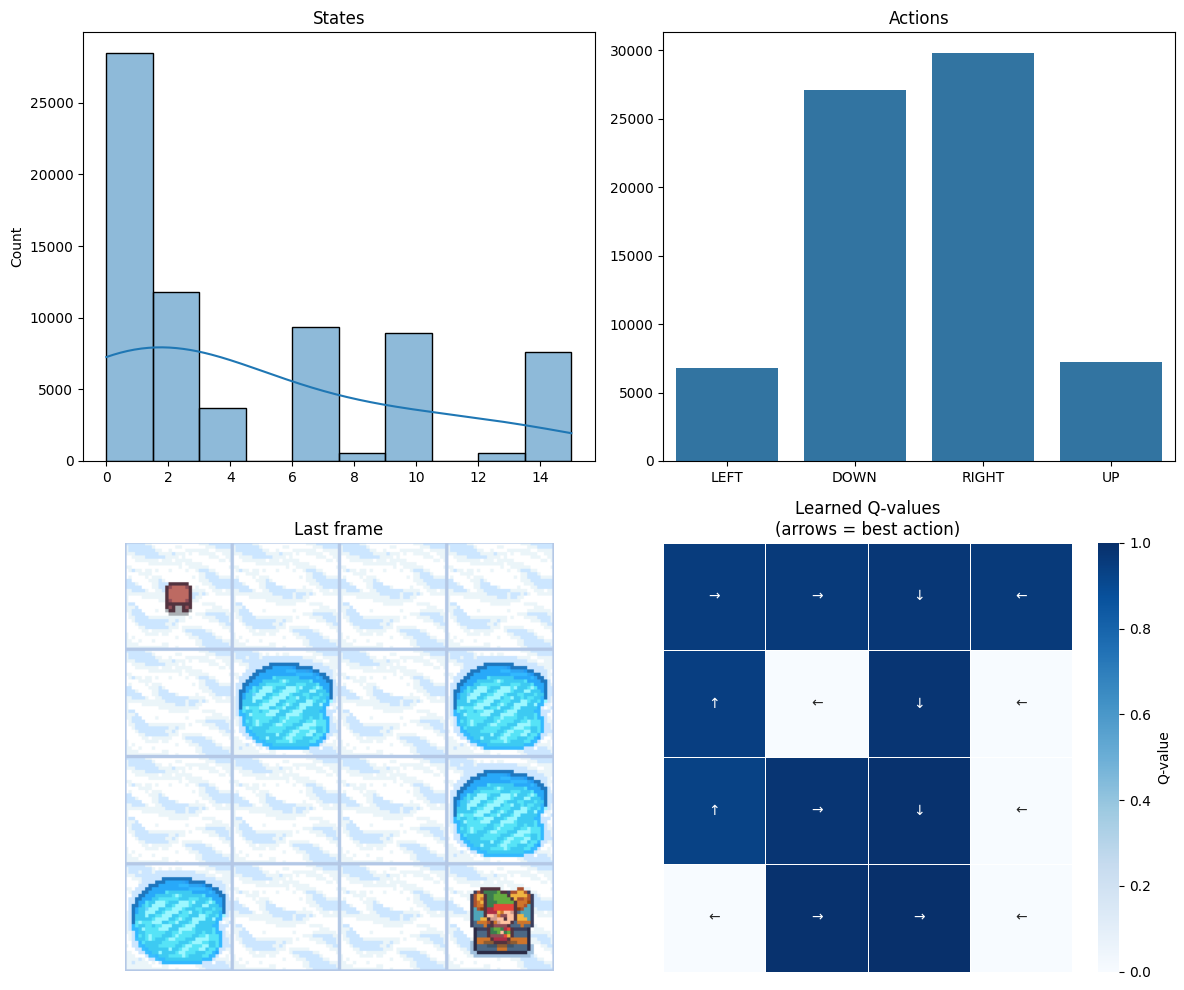

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym


env = gym.make("FrozenLake-v1",map_name="4x4",  is_slippery=False, render_mode="rgb_array")

Q, rewards, steps, eps_history, state_counts, action_counts, last_frame = q_learning(env)



import matplotlib.pyplot as plt
import seaborn as sns

size = int(np.sqrt(env.observation_space.n))
q_max    = Q.max(axis=1).reshape(size, size)
best_act = Q.argmax(axis=1).reshape(size, size)
arrow_dict = {0:"←",1:"↓",2:"→",3:"↑"}
arrows = np.vectorize(arrow_dict.get)(best_act)

fig, axes = plt.subplots(2, 2, figsize=(12,10))


sns.histplot(x=np.arange(len(state_counts)),
             weights=state_counts,
             kde=True, ax=axes[0,0])
axes[0,0].set_title("States")


sns.barplot(x=["LEFT","DOWN","RIGHT","UP"],
            y=action_counts, ax=axes[0,1])
axes[0,1].set_title("Actions")


axes[1,0].imshow(last_frame)
axes[1,0].axis("off")
axes[1,0].set_title("Last frame")


sns.heatmap(q_max,
            annot=arrows,
            fmt="",
            cmap="Blues",
            cbar_kws={"label":"Q-value"},
            linewidths=0.5,
            xticklabels=False,
            yticklabels=False,
            ax=axes[1,1])
axes[1,1].set_title("Learned Q‑values\n(arrows = best action)")

plt.tight_layout()
plt.show()


# **Part 2: Deep Q-Learning on an Atari Game Environment**

In [ ]:
!pip install gym[atari] autorom[accept-rom-license]

In [ ]:
import numpy as np
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_


import gym
from gym.wrappers import AtariPreprocessing, FrameStack
import random
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## **Implementation of Deep Q-Learning on Asteroids Atari Game Environment**

In [ ]:
env = gym.make("AsteroidsNoFrameskip-v4")
env = AtariPreprocessing(
    env,
    grayscale_obs=True,
    scale_obs=True,
    noop_max=30,
    frame_skip=4,
    terminal_on_life_loss=True
)
env = FrameStack(env, num_stack=4)


num_episodes    = 300
gamma           = 0.99
epsilon_start   = 1.0
epsilon_end     = 0.1
epsilon_decay   = 1e6
learning_rate   = 1e-4
batch_size      = 32
target_update   = 1000
memory_capacity = 100_000
device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_actions = env.action_space.n


class DQN(nn.Module):
    def __init__(self, n_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512), nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x):
        x = x.float() / 255.0
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


Transition = namedtuple('Transition', ('state','action','reward','next_state','done'))
class ReplayMemory:
    def __init__(self, capacity): self.buffer = deque(maxlen=capacity)
    def push(self, *args): self.buffer.append(Transition(*args))
    def sample(self, k):
        batch = random.sample(self.buffer, k)
        return Transition(*zip(*batch))
    def __len__(self): return len(self.buffer)

train_rewards = []
train_losses  = []

def q_learning(env,
               num_episodes=300,
               gamma=0.99,
               epsilon_start=1.0,
               epsilon_end=0.1,
               epsilon_decay=1e6,
               lr=1e-4,
               batch_size=32,
               target_update=1000,
               memory_capacity=100_000):

    policy_net = DQN(env.action_space.n).to(device)
    target_net = DQN(env.action_space.n).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayMemory(memory_capacity)
    steps_done = 0


    train_rewards = []
    train_losses  = []

    def select_action(state):
        nonlocal steps_done
        eps = epsilon_end + (epsilon_start - epsilon_end) * \
              np.exp(-1.0 * steps_done / epsilon_decay)
        steps_done += 1
        if random.random() < eps:
            return torch.tensor([[random.randrange(n_actions)]], device=device)
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1,1)

    for ep in range(num_episodes):
        obs, _ = env.reset()
        state = torch.tensor(np.array(obs), device=device).unsqueeze(0)
        total_reward = 0
        done = False

        while not done:
            action = select_action(state)
            next_obs, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            next_state = torch.tensor(np.array(next_obs), device=device).unsqueeze(0)

            memory.push(state.squeeze(0).cpu().numpy(),
                        action,
                        reward,
                        next_state.squeeze(0).cpu().numpy(),
                        done)
            state = next_state
            total_reward += reward

            # optimization
            if len(memory) >= batch_size:
                trans = memory.sample(batch_size)
                s_batch  = torch.stack([torch.tensor(s, device=device) for s in trans.state])
                ns_batch = torch.stack([torch.tensor(s, device=device) for s in trans.next_state])
                a_batch  = torch.cat(trans.action)
                r_batch  = torch.tensor(trans.reward, device=device).unsqueeze(1)
                d_batch  = torch.tensor(trans.done, device=device).unsqueeze(1)

                q_vals = policy_net(s_batch).gather(1, a_batch)
                with torch.no_grad():
                    next_q = target_net(ns_batch).max(1)[0].unsqueeze(1)
                    target = r_batch + (1 - d_batch.float()) * gamma * next_q

                loss = F.smooth_l1_loss(q_vals, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


                train_losses.append(loss.item())


            if steps_done % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())


        train_rewards.append(total_reward)
        print(f"Episode {ep+1}/{num_episodes} → Reward: {total_reward}")


    return policy_net, train_rewards, train_losses


trained_net, train_rewards, train_losses = q_learning(
    env,
    num_episodes=300,
    gamma=gamma,
    epsilon_start=epsilon_start,
    epsilon_end=epsilon_end,
    epsilon_decay=epsilon_decay,
    lr=learning_rate,
    batch_size=batch_size,
    target_update=target_update,
    memory_capacity=memory_capacity
)


torch.save(trained_net.state_dict(), "dqn_asteroids_adapted.pth")


Episode 1/300 → Reward: 90.0
Episode 2/300 → Reward: 390.0
Episode 3/300 → Reward: 20.0
Episode 4/300 → Reward: 310.0
Episode 5/300 → Reward: 70.0
Episode 6/300 → Reward: 20.0
Episode 7/300 → Reward: 20.0
Episode 8/300 → Reward: 340.0
Episode 9/300 → Reward: 20.0
Episode 10/300 → Reward: 90.0
Episode 11/300 → Reward: 240.0
Episode 12/300 → Reward: 290.0
Episode 13/300 → Reward: 20.0
Episode 14/300 → Reward: 20.0
Episode 15/300 → Reward: 480.0
Episode 16/300 → Reward: 70.0
Episode 17/300 → Reward: 60.0
Episode 18/300 → Reward: 40.0
Episode 19/300 → Reward: 40.0
Episode 20/300 → Reward: 310.0
Episode 21/300 → Reward: 40.0
Episode 22/300 → Reward: 40.0
Episode 23/300 → Reward: 40.0
Episode 24/300 → Reward: 20.0
Episode 25/300 → Reward: 110.0
Episode 26/300 → Reward: 170.0
Episode 27/300 → Reward: 140.0
Episode 28/300 → Reward: 90.0
Episode 29/300 → Reward: 70.0
Episode 30/300 → Reward: 40.0
Episode 31/300 → Reward: 20.0
Episode 32/300 → Reward: 240.0
Episode 33/300 → Reward: 20.0
Episode 

## **Visualization of Asteroids Atari Game Environment**

In [ ]:

!pip install -q imageio


import gym
from gym.wrappers.atari_preprocessing import AtariPreprocessing
from gym.wrappers.frame_stack import FrameStack
import imageio
import torch
import torch.nn as nn
import numpy as np
from base64 import b64encode
from IPython.display import HTML


raw_env = gym.make("AsteroidsNoFrameskip-v4")
env = AtariPreprocessing(
    raw_env,
    grayscale_obs=True,
    scale_obs=True,
    noop_max=30,
    frame_skip=4,
    terminal_on_life_loss=True
)
env = FrameStack(env, num_stack=4)


class DQN(nn.Module):
    def __init__(self, n_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512), nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x):
        x = x.float() / 255.0
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DQN(env.action_space.n).to(device)
model.load_state_dict(torch.load("dqn_asteroids_adapted.pth", map_location=device))
model.eval()


def get_raw_ale(env):
    e = env
    while hasattr(e, "env"):
        e = e.env
    return e.ale
ale = get_raw_ale(env)


frames = []
obs, _ = env.reset()

frames.append(ale.getScreenRGB())

done = False
while not done:

    state = torch.tensor(np.array(obs), device=device).unsqueeze(0)
    with torch.no_grad():
        action = model(state).argmax(1).item()
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    frames.append(ale.getScreenRGB())


video_path = "asteroids_demo.mp4"
imageio.mimsave(video_path, frames, fps=30)


mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=480 controls>
  <source src="{data_url}" type="video/mp4">
</video>
""")


## **Training Rewards Plot on Asteroids**

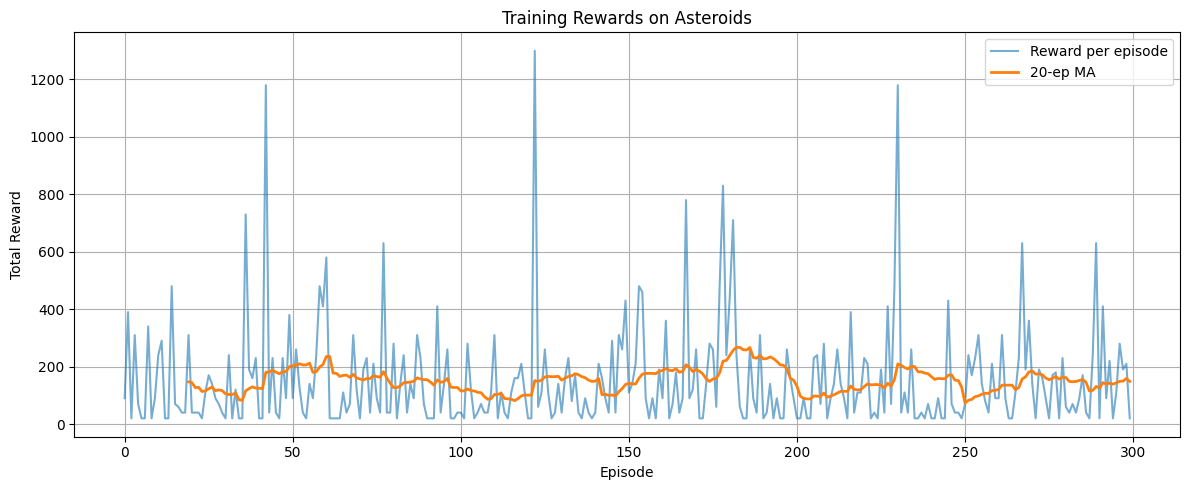

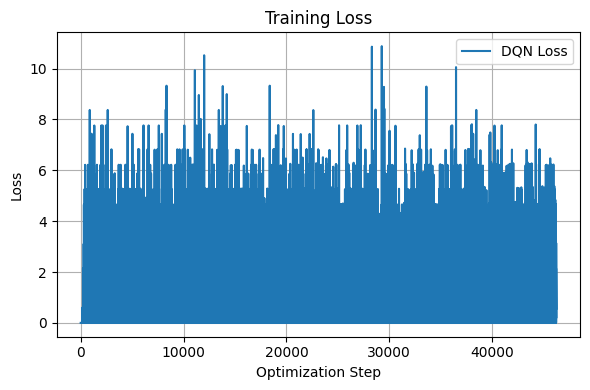

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(12,5))
plt.plot(train_rewards, alpha=0.6, label="Reward per episode")

window = 20
ma = np.convolve(train_rewards, np.ones(window)/window, mode="valid")
plt.plot(range(window-1, len(train_rewards)), ma, color="C1", lw=2, label=f"{window}-ep MA")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Rewards on Asteroids")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


if train_losses:
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="DQN Loss")
    plt.xlabel("Optimization Step")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
